In [3]:
import numpy as np
from filterpy.kalman import KalmanFilter
import pandas as pd
import matplotlib.pyplot as plt
import quaternion
from mpl_toolkits.mplot3d import Axes3D


# Orientation estimation using extended kalman filter
  Based on: X. Yun and E. R. Bachmann, ‘Design, Implementation, and Experimental Results of a Quaternion-Based Kalman Filter for Human Body Motion Tracking’, IEEE Trans. Robot., vol. 22, no. 6, pp. 1216–1227, Dec. 2006, doi: 10.1109/TRO.2006.886270.
  
The state vector contains 3D angular velocity and quaternion: $$
\vec{x} = \begin{pmatrix} \omega_x & \omega_y & \omega_z & q_1 & q_2 & q_3 & q_4 \end{pmatrix}^T
$$


In [4]:
# this is the Jacobian (linearized version) of the state transition, equation (13)
def phi(x, Ts, tau1, tau2, tau3):
    return np.array([[np.exp(-Ts/tau1), 0, 0, 0, 0, 0, 0],
                    [0, np.exp(-Ts/tau2), 0, 0, 0, 0, 0],
                    [0, 0, np.exp(-Ts/tau3), 0, 0, 0, 0],
                    [-(x[4]*Ts)/2, -(x[5]*Ts)/2, -(x[6]*Ts)/2, 1, -(x[0]*Ts)/2, -(x[1]*Ts)/2, -(x[2]*Ts)/2],
                    [(x[3]*Ts)/2, -(x[6]*Ts)/2, (x[5]*Ts)/2, (x[0]*Ts)/2, 1, (x[2]*Ts)/2, -(x[1]*Ts)/2],
                    [(x[6]*Ts)/2, (x[3]*Ts)/2, -(x[4]*Ts)/2, (x[1]*Ts)/2, -(x[2]*Ts)/2, 1, (x[0]*Ts)/2],
                    [-(x[5]*Ts)/2, (x[4]*Ts)/2, (x[3]*Ts)/2, (x[2]*Ts)/2, (x[1]*Ts)/2, -(x[0]*Ts)/2, 1]])

# https://theshamblog.com/flying-around-3d-plots-with-an-imu-and-quaternions/
def quat_to_elev_azim_roll(q, angle_offsets=(0, 0, 0)):
    q0, q1, q2, q3 = q.w, q.x, q.y, q.z
    phi = np.arctan2(-2*q1*q2 + 2*q0*q3, q1**2 + q0**2 - q3**2 - q2**2)
    theta = np.arcsin(2*q1*q3 + 2*q0*q2)
    psi = np.arctan2(-2*q2*q3 + 2*q0*q1, q3**2 - q2**2 - q1**2 + q0**2)
    azim = np.rad2deg(phi) + angle_offsets[0]
    elev = np.rad2deg(-theta) + angle_offsets[1]
    roll = np.rad2deg(psi) + angle_offsets[2]
    return elev, azim, roll

In [5]:
kf = KalmanFilter(dim_x=7, dim_z=7)
kf.x = np.array([0., 0., 0., 0., 0., 0., 0.])
Ts = 0.04  # 25Hz samples

kf.H = np.eye(7)

tau1 = 0.5
tau2 = 0.5
tau3 = 0.5
D = 0.4

q11 = (D/(2*tau1))*(1 - np.exp(-(2*Ts)/tau1))
q22 = (D/(2*tau1))*(1 - np.exp(-(2*Ts)/tau2))
q33 = (D/(2*tau1))*(1 - np.exp(-(2*Ts)/tau3))

kf.Q = np.array([
    [q11, 0, 0, 0, 0, 0, 0],
    [0, q22, 0, 0, 0, 0, 0],
    [0, 0, q33, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0]])

kf.R =  np.array([
    [0.01, 0, 0, 0, 0, 0, 0],
    [0, 0.01, 0, 0, 0, 0, 0],
    [0, 0, 0.01, 0, 0, 0, 0],
    [0, 0, 0, 0.0001, 0, 0, 0],
    [0, 0, 0, 0, 0.0001, 0, 0],
    [0, 0, 0, 0, 0, 0.0001, 0],
    [0, 0, 0, 0, 0, 0, 0.0001]])

kf.P *= 1000

In [12]:
measured_elev, measured_azim, measured_roll = [], [], []
predicted_elev, predicted_azim, predicted_roll = [], [], []

#waiting for data with quaternions and angular velocities
df = pd.read_csv('spiral_data/sensor_data_down_b.csv')

for i, row in df.iterrows():
    z = [row['Gyro_X'], row['Gyro_Y'] ,row['Gyro_Z'], row['Quaternion_W'],row['Quaternion_X'],row['Quaternion_Y'],row['Quaternion_Z']] #should take wx,wy,wz,q1,q2,q3,q4
    
    kf.F = phi(kf.x, Ts, tau1, tau2, tau3)
    kf.predict()
    kf.update(z)
    
    q_measured = np.quaternion(z[3], z[4], z[5], z[6])
    elev, azim, roll = quat_to_elev_azim_roll(q_measured, (0,0,0))
    measured_elev.append(elev)
    measured_azim.append(azim)
    measured_roll.append(roll)
    
    x = kf.x
    q_predicted = np.quaternion(x[3], x[4], x[5], x[6])
    elev, azim, roll = quat_to_elev_azim_roll(q_predicted, (0,0,0))
    predicted_elev.append(elev)
    predicted_azim.append(azim)
    predicted_roll.append(roll)

C:\Users\diete\AppData\Local\Temp\ipykernel_14132\3676785636.py:15: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(2*q1*q3 + 2*q0*q2)


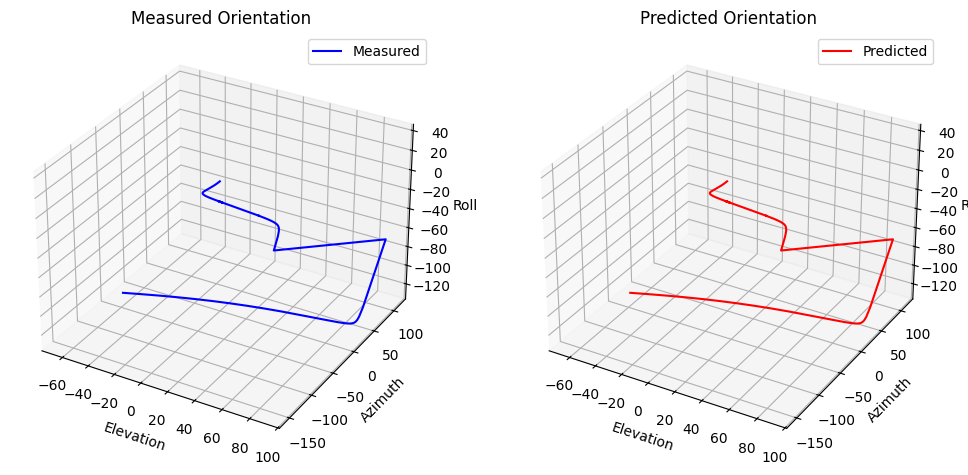

In [33]:
fig = plt.figure(figsize=(12, 8))

ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(measured_elev, measured_azim, measured_roll, label='Measured', color='blue')
ax1.set_xlabel('Elevation')
ax1.set_ylabel('Azimuth')
ax1.set_zlabel('Roll')
ax1.set_title('Measured Orientation')
ax1.legend()

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(predicted_elev, predicted_azim, predicted_roll, label='Predicted', color='red')
ax2.set_xlabel('Elevation')
ax2.set_ylabel('Azimuth')
ax2.set_zlabel('Roll')
ax2.set_title('Predicted Orientation')
ax2.legend()

plt.show()